<a href="https://colab.research.google.com/github/robertsaitov/DigitClassifier/blob/main/DigitClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 7.6MB/s 
     |████████████████████████████████| 1.2MB 14.6MB/s 
     |████████████████████████████████| 51kB 8.2MB/s 
     |████████████████████████████████| 194kB 35.3MB/s 
     |████████████████████████████████| 51kB 8.2MB/s 
     |████████████████████████████████| 61kB 9.0MB/s 
Mounted at /content/gdrive


In [ ]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

ModuleNotFoundError: ignored

# Intro to project and load dataset images

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path
path.ls()

(#3) [Path('train'),Path('valid'),Path('labels.csv')]

The MNIST dataset follows a common layout for machine learning datasets: separate folders for the training set and the validation set (and/or test set). Let's see what's inside the training set:

In [ ]:
(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

In [ ]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [ ]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In a computer, everything is represented as a number. To view the numbers that make up this image, we have to convert it to a NumPy array or a PyTorch tensor. For instance, here's what a section of the image looks like, converted to a NumPy array:

In [ ]:
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

This is PyTorch Tensor. The 4:10 indicates we requested the rows from index 4 (included) to 10 (not included) and the same for the columns.

In [ ]:
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

We can slice the array to pick just the part with the top of the digit in it, and then use a Pandas DataFrame to color-code the values using a gradient, which shows us clearly how the image is created from the pixel values:

In [ ]:
#hide_output
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


We will use Jupyter to do some little checks of our work along the way—in this case, making sure that the number of returned items seems reasonable:

In [ ]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

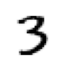

In [ ]:
show_image(three_tensors[1]);

For every pixel position, we want to compute the average over all the images of the intensity of that pixel. To do this we first combine all the images in this list into a single three-dimensional tensor. The most common way to describe such a tensor is to call it a rank-3 tensor. We often need to stack up individual tensors in a collection into a single tensor. Unsurprisingly, PyTorch comes with a function called stack that we can use for this purpose.

In [ ]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

In [ ]:
len(stacked_threes.shape)

3

We can also get a tensor's rank directly with ndim:

In [ ]:
stacked_threes.ndim

3

Finally, we can compute what the ideal 3 looks like. We calculate the mean of all the image tensors by taking the mean along dimension 0 of our stacked, rank-3 tensor. This is the dimension that indexes over all the images.

In other words, for every pixel position, this will compute the average of that pixel over all images. The result will be one value for every pixel position, or a single image. Here it is:


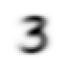

In [ ]:
mean3 = stacked_threes.mean(0)
show_image(mean3);

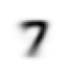

In [ ]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

Let's now pick an arbitrary 3 and measure its distance from our "ideal digits."



Here's a test sample:

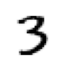

In [ ]:
a_3 = stacked_threes[1]
show_image(a_3);

We can compare pixels in two images to each other and add up all differences to see how big is the difference. It can vary from negative to positive. 
But this is a faulsy way of thinking. An image that is too dark in some places and too light in others might be shown as having zero total differences from the ideal.
To avoid this, there are two main ways data scientists measure distance in this context:


*   Take the mean of the absolute value of differences (absolute value is the function that replaces negative values with positive values). This is called the mean absolute difference or L1 norm
*   Take the mean of the square of differences (which makes everything positive) and then take the square root (which undoes the squaring). This is called the root mean squared error (RMSE) or L2 norm.



    

In [ ]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs,dist_3_sqr


(tensor(0.1114), tensor(0.2021))

In [ ]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

In both cases, the distance between our 3 and the "ideal" 3 is less than the distance to the ideal 7. So our simple model will give the right prediction in this case.

PyTorch already provides both of these as loss functions. You'll find these inside torch.nn.functional, which the PyTorch team recommends importing as F (and is available by default under that name in fastai):

In [ ]:
F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

Here mse stands for mean squared error, and l1 refers to the standard mathematical jargon for mean absolute value (in math it's called the L1 norm).

# Computing Metrics Using Broadcasting

So to start with, let's create tensors for our 3s and 7s from that directory. These are the tensors we will use to calculate a metric measuring the quality of our first-try model, which measures distance from an ideal image:

In [ ]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

We ultimately want to write a function, is_3, that will decide if an arbitrary image is a 3 or a 7. It will do this by deciding which of our two "ideal digits" this arbitrary image is closer to. For that we need to define a notion of distance—that is, a function that calculates the distance between two images.

We can write a simple function that calculates the mean absolute error using an expression very similar to the one we wrote in the last section:

In [ ]:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))
mnist_distance(a_3, mean3)